# Evaluate Trained DL Model in Colab

Demonstrates end-to-end pipeline (pre-processing, training, prediction and validation statistics)

In [368]:
import os
import os.path as osp

import glob

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

from tqdm import tqdm  # progress bar

from sklearn.metrics import r2_score
from sklearn.metrics import jaccard_score as jsc

# local imports
import transforms as T
from task_3_utils import evaluate, evaluate_loss, eval_binary_iou, pretty_image
from folder2lmdb import VOCSegmentationLMDB

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [359]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Found GPU,', device)

Found GPU, cuda


In [105]:
root = '/scratch/gallowaa/cciw/logs/lab-v1.0.0/fcn8slim/lr1e-03/wd5e-04/bs32/ep50/seed1/checkpoint'

ckpt_file = 'fcn8slim_lr1e-03_wd5e-04_bs32_ep50_seed1_epoch40.ckpt'

print('==> Resuming from checkpoint..')
checkpoint = torch.load(os.path.join(root, ckpt_file))
net = checkpoint['net']
train_loss = checkpoint['trn_loss']
val_loss = checkpoint['val_loss']
last_epoch = checkpoint['epoch']
torch.set_rng_state(checkpoint['rng_state'])

print('Loaded model trained to epoch ', last_epoch)
print('Cross-entropy loss {:.4f} for train set, {:.4f} for validation set'.format(train_loss, val_loss))

==> Resuming from checkpoint..
Loaded model trained to epoch  40
Cross-entropy loss 0.0807 for train set, 0.1903 for validation set


In [ ]:
#root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/'
#img = cv2.imread(os.path.join(root_path, test_file))
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define Image Pre-Processing Transforms and Data Augmentation

Here, we define transforms to be applied to input images (`inputs`) and segmentation masks (`targets`)
on the fly as we draw mini-batches like:

```
for inputs, targets in dataloader:
    pass
```

These transforms are documented here: https://pytorch.org/docs/stable/torchvision/transforms.html

We may wish to experiment with additional ones in the future, e.g., `ColorJitter` to perturb the image colours, 
or `Grayscale` to convert the dataset to Greyscale and quantify the marginal impact of colour information on model performance.

In [8]:
training_tforms = []

# Randomly crop images to square 224x224
training_tforms.append(T.RandomCrop(224)) 

# With probability 0.5, flip the images and masks horizontally.
# This increases the effective size of our training set, as 
# mussels are rotation invariant.
training_tforms.append(T.RandomHorizontalFlip(0.5)) 

# Similarly, flip the images and masks vertically with probability 0.5.
training_tforms.append(T.RandomVerticalFlip(0.5))

# Convert images from Python Imaging Library (PIL aka Pillow) format to PyTorch Tensor.
training_tforms.append(T.ToTensor())

"""
T.Normalize performs: image = (image - mean) / std

The first argument (a triple) to T.Normalize are the global 
RGB pixel mean values, and the second argument is their standard deviation. 

For a mini-batch 'inputs' comprised of N samples, 
C channels, e.g. 3 for RGB images, height H, width W, and 
inputs.shape = torch.Size([N, C, H, W]), this can be obtained using:

inputs.mean(dim=(0, 2, 3)), which will output a tensor, e.g., 
tensor([0.2613, 0.2528, 0.2255]). 

The standard deviation can be obtained similarly with:
inputs.std(dim=(0, 2, 3))

The global values can simply be obtained by averaging over all 
mini-batches in the dataset.

For the natural mussel dataset (i.e. not the Lab images), 
these global pixel values are somewhat meaningless to due 
significant changes in lighting and hue, so we simply
pass the triple (0.5, 0.5, 0.5) for both mean and std to
normalize the input image pixels from [0, 1] to [-1, 1]. 
This centers the images and resulting feedforward activations 
around zero and allows training to proceed more smoothly.
"""
training_tforms.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

# Finally, Compose several transforms together.
training_tforms = T.Compose(training_tforms)

For validation and testing, we often want these transforms to be deterministic to be sure the model is making progress with respec to the natural image distribution. We will evaluate on fixed 250x250 patches rather than randomly cropping.

For evaluating robustness, we could add `ColorJitter` and do scaling or shearing with various Affine transforms here...

In [9]:
test_tform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Specify mini-batch size (`batch_size`) for validation, and path to serialized LMDB dataset `dataset_root`. 

The `batch_size` is arbitrary at test time since we aren't using `nn.BatchNorm()`, the main consideration here 
is to use the largest `batch_size` the GPU memory allows to maximize throughput.

In [10]:
batch_size = 50
dataset_root = '/scratch/ssd/gallowaa/cciw/Lab'

In [11]:
validation_set = VOCSegmentationLMDB(
    root=osp.join(dataset_root, 'val_v100.lmdb'), transforms=test_tform)

val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [12]:
training_set = VOCSegmentationLMDB(
    root=osp.join(dataset_root, 'train_v100.lmdb'), transforms=test_tform)

train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=False)

To compute the `pos_weight` from the dataset, uncomment the following cell.

Note that the `batch_pos_weight` may be `inf` for a batch comprised entirely of 
masks without any mussels. Increase the `batch_size` to avoid this.

In [ ]:
"""
running_mean = 0.
for idx, data in enumerate(train_loader):
    batch_pos_weight = 1 / ((data[1] == 1).sum().float() / (data[1] == 0).sum())
    running_mean += batch_pos_weight
    print('Batch %d of %d, pos_weight=%.4f' % (idx, len(train_loader), batch_pos_weight))
pos_weight = running_mean / len(train_loader)
print('pos_weight={:.4f}'.format(pos_weight))
"""

In [107]:
#pos_weight = torch.FloatTensor([6.5546]).to(device)
pos_weight = torch.FloatTensor([12.4924]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

sig = nn.Sigmoid()  # initializes a sigmoid function

# Compute training and validation cross-entropy losses

to ensure model was loaded correctly and that the data were pre-processed in consistent manner w.r.t. the training script.

Note: the cross-entropy loss is a proxy for what we ultimately want to measure, the intersection of the prediction and masks divided by their union.

In [108]:
calculate_validation_loss = evaluate_loss(net, val_loader, loss_fn, device)
assert np.allclose(calculate_validation_loss, val_loss)
print('Validation loss of {:.4f} matches checkpoint'.format(calculate_validation_loss))

100%|██████████| 27/27 [00:09<00:00,  2.85it/s]

Validation loss of 0.1903 matches checkpoint


In [ ]:
# note: train loss may not match exactly 

calculate_train_loss = evaluate_loss(net, train_loader, loss_fn, device)
print('Calculated train loss of {:.4f}'.format(calculate_train_loss))
print('Checkpoint train loss of {:.4f}'.format(train_loss))

# Compute Intersection-over-Union Score

The mean Intersection-over-Union (IoU), aka Jaccard Score or Jaccard Index, on the validation/test dataset is 
the main performance metric we use to evaluate semantic segmentation models.

Note: using `torch.no_grad()` saves memory if we will not be 
doing error backpropagation as intermediate activations can be 
discarded. Otherwise these are retained in GPU memory in case 
we want to compute gradients. 

See https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad

In [112]:
batch = 0
running_iou = 0

with torch.no_grad():
    
    for inputs, targets in tqdm(val_loader, unit=' images', unit_scale=batch_size):
        inputs, targets = inputs.to(device), targets.to(device)
        
        """Apply the sigmoid function here so that output lies in [0, 1]. 
        Previously it was applied internally by the loss_fn"""
        pred = sig(net(inputs))
        bin_iou = eval_binary_iou(pred.round(), targets)
        
        if (bin_iou > 0).sum() > 1:
            iou = bin_iou[bin_iou > 0].mean().item()
            running_iou += iou
            batch += 1
    running_iou = running_iou / batch

print('mIoU = %.4f' % running_iou)

100%|██████████| 1350/1350 [00:09<00:00, 139.83 images/s]

mIoU = 0.8638


# Visualize Predictions

In [329]:
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

In [113]:
nhwc = inputs.permute(0, 2, 3, 1).detach().cpu().numpy()
pred_np = pred.detach().cpu().numpy()
targets_np = targets.detach().cpu().numpy()

# put pixels back into range [0, 1] for matplotlib
nhwc = (nhwc * 0.5) + 0.5

print(nhwc.shape)
print(nhwc.min())
print(nhwc.max())

(46, 250, 250, 3)
0.0
1.0


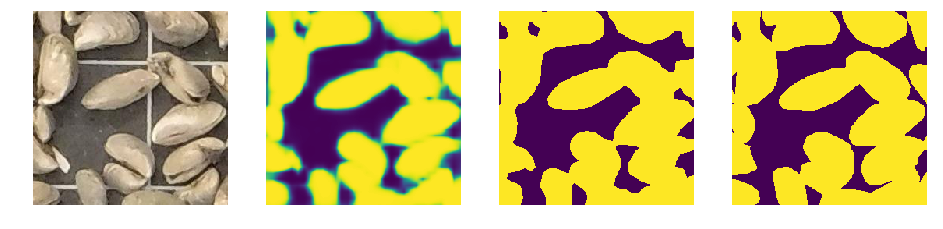

In [114]:
j = 0

N_PLOTS = 4
fig, ax = plt.subplots(1, N_PLOTS, figsize=(16, 4))

ax[0].imshow((nhwc[j]))
ax[1].imshow(pred_np[j].squeeze())
ax[2].imshow(pred_np[j].round().squeeze())
ax[3].imshow(targets_np[j])

for i in range(N_PLOTS):
    ax[i].axis('off')

In [50]:
root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/'
jpeg_files = glob.glob(root_path + '*.jpg')
png_files = glob.glob(root_path + '*_final.png')
jpeg_files.sort()
png_files.sort()
print(len(jpeg_files))
print(len(png_files))

36
36


In [69]:
val_jpeg = jpeg_files[-5:]
val_jpeg

['/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3796-1_2018-08-13_image-1.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3798-2_2018-08-13_image-1.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3800-3_2018-08-13_image-1.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3801-1_2018-07-11_image-1.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3801-3_2018-07-11_image-1.jpg']

In [70]:
val_mask = png_files[-5:]
val_mask

['/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3796-1_2018-08-13_image-1_mask_crf_gimp_final.png',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3798-2_2018-08-13_image-1_scale_final.png',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3800-3_2018-08-13_image-1_scale_final.png',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3801-1_2018-07-11_image-1_scale_final.png',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3801-3_2018-07-11_image-1_scale_final.png']

In [350]:
i = 0  # increment me to try new images

bgr_img = cv2.imread(osp.join(root_path, val_jpeg[i]))
bgr_lab = cv2.imread(osp.join(root_path, val_mask[i]))

img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
lab = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)

w = 1000  # to keep memory consumption reasonable, we take a wxw crop
sy = 50
sx = 1000

imgc = img[sy:sy + w, sx:sx + w, :]
labc = lab[sy:sy + w, sx:sx + w]

# pre-processing image consistent with PyTorch training transforms
imgc = imgc / 255
imgc = ((imgc - np.array([0.5, 0.5, 0.5])) / np.array([0.5, 0.5, 0.5]))

imgt = torch.FloatTensor(imgc).to(device)
imgt = imgt.unsqueeze(0)

# Note: need to call contigious after the permute 
# else max pooling will fail
nchw_tensor = imgt.permute(0, 3, 1, 2).contiguous()

with torch.no_grad():
    pred = sig(net(nchw_tensor))
    
inputs_nhwc = nchw_tensor.permute(0, 2, 3, 1)

inputs_nhwc_np = inputs_nhwc.detach().cpu().numpy()

# put pixels back into range [0, 1] for matplotlib
inputs_nhwc_np = (inputs_nhwc_np * 0.5) + 0.5

pred_np = pred.detach().cpu().numpy()

# OpenCV loads the PNG mask as indexed color RGB, 
# we need to convert it to a binary mask. 
# The `0' in labc[:, :, 0] is the R channel.
mask = np.zeros((w, w), dtype='float32')
mask[labc[:, :, 0] == 128] = 1

image = (inputs_nhwc_np.squeeze() * 255).astype('uint8')
pred_np = pred_np.squeeze()

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html
jaccard_fcn = jsc(pred_np.round().reshape(-1, 1), mask.reshape(-1, 1))
print('FCN IoU %.4f' % jaccard_fcn)

FCN IoU 0.8370


<IPython.core.display.Javascript object>


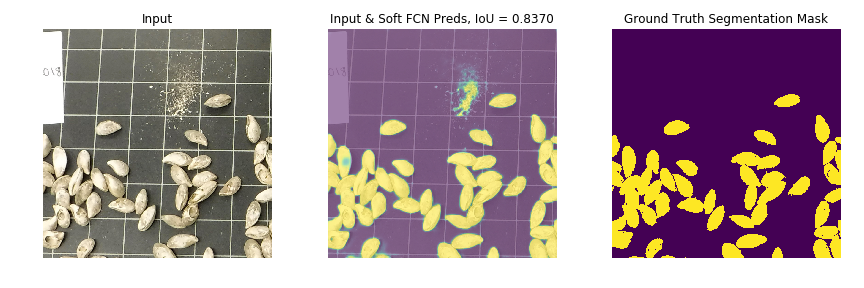

In [357]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

axes[0].imshow(image)
axes[0].set_title('Input')

axes[1].imshow(image, alpha=0.5)
axes[1].imshow(pred_np, alpha=0.5)
axes[1].set_title('Input & Soft FCN Preds, IoU = %.4f' % jaccard_fcn)

axes[2].imshow(mask)
axes[2].set_title('Ground Truth Segmentation Mask')

pretty_image(axes)

#fig.savefig('img/' + ckpt_file.split('.')[0] + '_' + files[i].split('.')[0] + '_full.png')

# Refine the Predictions with a CRF

In [340]:
def run_crf(rgb, pred_np):
    """
    Takes an input image and corresponding model predictions, then 
    runs a conditional random field (CRF) on the predictions.
    
    @param rgb: is an rgb image in uint8 format (pixels 0-255)
    @param pred_np: are model predictions in greyscale format as float [0,1]
    """
    MAX_ITER = 20
    labels = np.stack([pred_np, 1 - pred_np])
    c, h, w = labels.shape[0], labels.shape[1], labels.shape[2]
    labels = labels.astype('float') / labels.max()
    U = utils.unary_from_softmax(labels)
    U = np.ascontiguousarray(U)
    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    """
    @param compat=3, Potts model - it introduces a penalty for nearby similar 
    pixels that are assigned different labels. 
    """
    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=3, compat=6)
    
    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    # im is an image-array, e.g. im.dtype == np.uint8
    d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=rgb, compat=10)
    
    Q = d.inference(MAX_ITER)
    Q = np.array(Q).reshape((c, h, w))
    # binarize output
    Q[0][Q[0] >= 0.5] = 1
    Q[0][Q[0] < 0.5] = 0
    
    return Q[0, :, :]

In [351]:
pred_crf = run_crf(image, pred_np)
jaccard_crf = jsc(pred_crf.reshape(-1, 1), mask.reshape(-1, 1))
print('CRF IoU %.4f' % jaccard_crf)

CRF IoU 0.9352


<IPython.core.display.Javascript object>


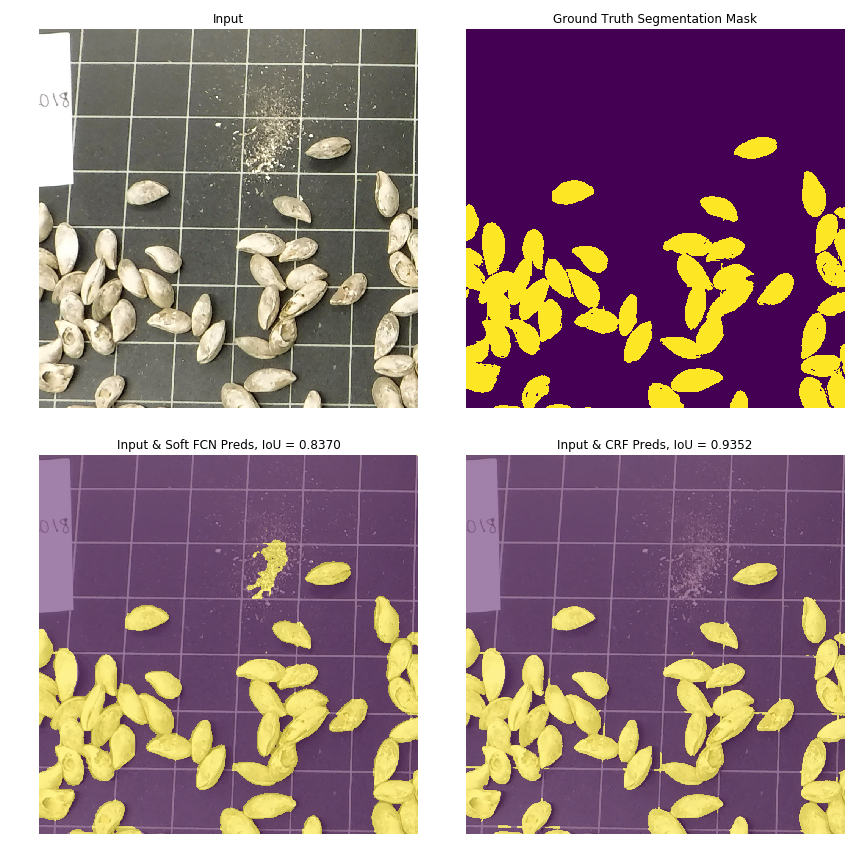

In [354]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

axes[0].imshow(image)
axes[0].set_title('Input')

axes[1].imshow(mask)
axes[1].set_title('Ground Truth Segmentation Mask')

axes[2].imshow(image, alpha=0.75)
axes[2].imshow(pred_np.round(), alpha=0.5)
axes[2].set_title('Input & Soft FCN Preds, IoU = %.4f' % jaccard_fcn)

axes[3].imshow(image, alpha=0.75)
axes[3].imshow(pred_crf, alpha=0.5)
axes[3].set_title('Input & CRF Preds, IoU = %.4f' % jaccard_crf)

pretty_image(axes)

#fig.savefig('img/' + ckpt_file.split('.')[0] + '_' + files[i].split('.')[0] + '_full.png')

# Predict Biomass from Labels

In [377]:
DATA_PATH = r'/scratch/gallowaa/cciw/Data'
#MASK_PATH = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done'

imagetable_path = os.path.join(DATA_PATH, 'Tables', 'ImageTable.csv')
image_df = pd.read_csv(imagetable_path, index_col=0)
analysis_path = os.path.join(DATA_PATH, 'Tables', 'Analysis.csv')
dive_path = os.path.join(DATA_PATH, 'Tables', 'Dives.csv')
analysis_df = pd.read_csv(analysis_path, index_col=0, dtype={'Count':float})
dive_df = pd.read_csv(dive_path, index_col=0, parse_dates=['Date'])
data_df = pd.merge(analysis_df, dive_df, on='Dive Index', how='outer')

In [380]:
"""
numpy array with manually estimated camera distance based on counting 
squares along horizontal and vertical axes of each Lab image.

Useful to determine how much performance can be gained by accounting 
for camera distance programmatically."""
scale = np.load('lab_board_dims.npy')

In [381]:
all_images = glob.glob(os.path.join(root_path, '*_final.png'))
print(len(all_images))
all_images.sort()

36


In [407]:
lab_ct = []  # for storing the number of mussel pixels in each mask
prd_ct = []  # for storing the number of mussel pixels in each prediction

for i in tqdm(range(len(jpeg_files)), unit=' images'):
    
    bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))
    bgr_lab = cv2.imread(osp.join(root_path, png_files[i]))
    
    _, cts = np.unique(bgr_lab, return_counts=True)
    lab_ct.append(cts[1] / cts.sum())    
    
    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    lab = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)

    # pre-processing image consistent with PyTorch training transforms
    img = img / 255.
    img = ((img - np.array([0.5, 0.5, 0.5])) / np.array([0.5, 0.5, 0.5]))

    imgt = torch.FloatTensor(img).to(device)
    imgt = imgt.unsqueeze(0)

    # Note: need to call contigious after the permute 
    # else max pooling will fail
    nchw_tensor = imgt.permute(0, 3, 1, 2).contiguous()

    with torch.no_grad():
        pred = sig(net(nchw_tensor))
    
    prd_ct.append(pred.round().sum().item() / cts.sum())


100%|██████████| 36/36 [01:06<00:00,  1.84s/ images]


In [423]:
lab_ct_np = np.asarray(lab_ct)
prd_ct_np = np.asarray(prd_ct)

lab_targets = np.zeros((len(jpeg_files), 2)) # 0 = biomass, 1 = count

for i in range(len(jpeg_files)):
    
    # adjust the pixel_ct by size of grid
    lab_ct_np[i] = lab_ct_np[i] * (np.prod(scale[i]) / (16 * 25))
    prd_ct_np[i] = prd_ct_np[i] * (np.prod(scale[i]) / (16 * 25))
    
    if 'scale' in all_images[i]:
        root_fname = all_images[i].split('/')[-1].split('.')[0].split('_scale')[0][4:-8]
    else:
        root_fname = all_images[i].split('/')[-1].split('.')[0].split('_mask')[0][4:-8]
        
    guid = image_df[image_df['Name'].str.contains(root_fname)]['Analysis Index'].astype('int64')
    row = data_df[data_df['Analysis Index'].values == np.unique(guid.values)]
    lab_targets[i, 0] = row['Biomass'].values
    lab_targets[i, 1] = row['Count'].values
    
lab_ct_np = lab_ct_np / lab_ct_np.max()    
prd_ct_np = prd_ct_np / prd_ct_np.max()

lab_targets[np.isnan(lab_targets)] = 0
y = lab_targets[:, 0] / lab_targets[:, 0].max()

#r_val = np.corrcoef(lab_ct_np, y)[1, 0]

<IPython.core.display.Javascript object>


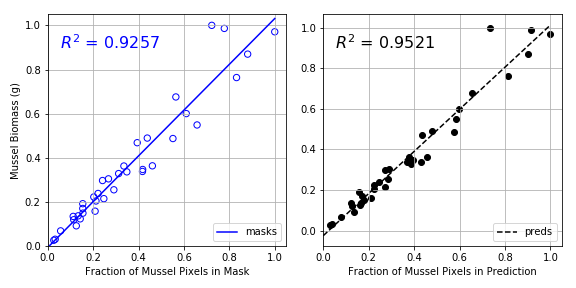

In [431]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

ax[0].scatter(lab_ct_np, y, marker='o', s=40, facecolors='none', edgecolors='b')
ax[1].scatter(prd_ct_np, y, c='k') #, marker='o', s=40, facecolors='none', edgecolors='k')
ax[0].set_ylabel('Mussel Biomass (g)')
ax[0].set_ylim(0, 1.05)
ax[0].set_xlim(0, 1.05)
ax[0].set_xlabel('Fraction of Mussel Pixels in Mask')
ax[1].set_xlabel('Fraction of Mussel Pixels in Prediction')

x = np.linspace(0, 1)

A = np.vstack([lab_ct_np, np.ones(len(lab_ct_np))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
ax[0].plot(x, m*x + c, 'b', linestyle='-', label='masks')

A = np.vstack([prd_ct_np, np.ones(len(prd_ct_np))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
ax[1].plot(x, m*x + c, 'k', linestyle='--', label='preds')

ax[0].annotate(r'$R^2$ = %.4f' % r2_score(y, lab_ct_np), 
            xy=(.05, .85), fontsize=16, xycoords='axes fraction', color='b')

ax[1].annotate(r'$R^2$ = %.4f' % r2_score(y, prd_ct_np), 
            xy=(.05, .85), fontsize=16, xycoords='axes fraction', color='k')

ax[0].grid()
ax[1].grid()

ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
plt.tight_layout()

In [ ]:
fname = 'Lab_predict_biomass_from_labels'
fig.savefig(fname + '.png')
fig.savefig(fname + '.eps', format='eps')